In [179]:
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.style.use('seaborn')
plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markeredgewidth'] = 1

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

import json
import re
from typing import Union

In [2]:
# Load results from JSON files
results_dir = "../results"

def libname_of_path(path):
    return re.search(".*lib(.*)\.so(.\d)?", path).group(1)


benchmarks = [
    'dlopen-dlclose',
    'dlsym',
    'function-call',
    'lazy-binding',
    # 'pngtest'
]

In [3]:
def load_benchmark_results(file_prefix: str, benchmark_type: Union[str, None] = None, print_iter_cnt: bool = False):
    
    if benchmark_type is None:
        benchmark_type = file_prefix

    with open(f"{results_dir}/{file_prefix}-baseline.json") as fp_baseline:
        res = dict()
        raw = json.load(fp_baseline)
        outer_iterations = raw[benchmark_type]['outer-iterations']
        inner_iterations = raw[benchmark_type]['inner-iterations']
        for lib in raw[benchmark_type]['libraries']:
            libname = libname_of_path(lib['library-path'])
            lib.pop('library-path')
            res[libname] = lib

        # We drop the first few iterations for each library because it will usually take longer due to paging in stuff etc.
        baseline = (pd.concat([pd.DataFrame(res[key]).assign(libname=key).set_index('libname').iloc[10:]
                              for key in res.keys()]) / inner_iterations
                   )
                   # ).assign(**{
                   #      'branch-mispredicts/branches(%)': lambda df: 100. * df.loc[:, 'branch-mispredicts'] / df.loc[:, 'branches']
                   # }).drop(columns=['branch-mispredicts'])

    with open(f"{results_dir}/{file_prefix}-sandbox.json") as fp_sandbox:
        res = dict()
        raw = json.load(fp_sandbox)
        assert raw[f'{benchmark_type}-sandbox']['outer-iterations'] == outer_iterations
        assert raw[f'{benchmark_type}-sandbox']['inner-iterations'] == inner_iterations
        for lib in raw[f'{benchmark_type}-sandbox']['libraries']:
            libname = libname_of_path(lib['library-path'])
            lib.pop('library-path')
            res[libname] = lib

        sandbox = (pd.concat([pd.DataFrame(res[key]).assign(libname=key).set_index('libname').iloc[10:]
                              for key in res.keys()]) / inner_iterations
                  )
                  # ).assign(**{
                  #      'branch-mispredicts/branches(%)': lambda df: 100. * df.loc[:, 'branch-mispredicts'] / df.loc[:, 'branches']
                  # }).drop(columns=['branch-mispredicts'])
        
    if print_iter_cnt:
        print(f"Outer iterations: {outer_iterations}, inner iteration: {inner_iterations}")
    
    return baseline, sandbox


In [439]:
def plot_benchmark_data(baseline: pd.DataFrame, sandbox: pd.DataFrame):
    
    libnames = set(baseline.index.values).intersection(sandbox.index.values)
    print(f"Libraries: {libnames}")
    counters = set(baseline.columns).intersection(sandbox.columns)
    print(f"Counters: {counters}")

    fig, axss = plt.subplots(nrows=len(libnames), ncols=len(counters), figsize=(12, 3*len(libnames)), sharey=True)
    plt.subplots_adjust(hspace=.4)
    
    if len(libnames) > 1:
        # Hack for correct order in dlopen-dlclose
        libnames = sorted(libnames)
        tmp = libnames[-2]
        libnames[-2] = libnames[-1]
        libnames[-1] = tmp

    for rowindex, libname in enumerate(libnames):
        axs = axss[rowindex] if len(libnames) > 1 else axss
        # axs[0].set_title(libname)
        if len(libnames) > 1:
            axs[0].set_ylabel(r'\texttt{lib' + libname + r'}') 

        # for counter, ax in zip(sorted(counters, reverse=True), axs.ravel()):
        for counter, ax in zip(counters, axs.ravel()):
            vals, bins, patches = ax.hist(
                [baseline.loc[libname, counter].values, sandbox.loc[libname, counter].values],
                bins=15, histtype='stepfilled',
                color=['blue', 'orange'], alpha=.4,
                # label=[benchmark, f'{benchmark}-sandbox']
            )
            baseline_median = baseline.loc[libname, counter].median()
            sandbox_median = sandbox.loc[libname, counter].median()
            ax.axvline(x=baseline_median, color='blue', lw=.7, label=f"{baseline_median:,.1f}")
            ax.axvline(x=sandbox_median, color='orange', lw=.7, label=f"{sandbox_median:,.1f}")
            ax.set_xlim(0, None)
            ax.set_ylim(0, 1000)
            ax.set_xlabel(counter)
            handles, labels = ax.get_legend_handles_labels()
            # handles.append(mpatches.Patch(color='white',
            #                               label=f"$\\%$ overhead: ${100 * (sandbox_median / baseline_median - 1):.2f}\\%$\\\\"
            #                                     "(median/median - $100\\%$)"))
            diff = np.abs(sandbox_median-baseline_median)
            _, xmax = ax.get_xlim()
            ax.annotate(f"${100 * (sandbox_median / baseline_median - 1):.2f}\\%$ overhead (${diff:.2f}$)",
                        xy=((sandbox_median+baseline_median)/2,1000),
                        xytext=((sandbox_median+baseline_median)/2,1020),
                        annotation_clip=False,
                        ha='center', va='bottom',
                        arrowprops=dict(arrowstyle=f'-[, widthB={7.36*diff/xmax}, lengthB=.2', lw=0.8))
            ax.legend(handles=handles, title='Medians')
            
    fig.legend(handles=[mpatches.Patch(color='blue', label=benchmark),
                        mpatches.Patch(color='orange', label=f'{benchmark}-sandbox')],
               loc='right')

    # fig.tight_layout()

    plt.show()

==== dlopen-dlclose ====
Libraries: {'z_nofio', 'hello_world', 'png'}
Counters: {'CPU_CYCLES', 'INST_RETIRED', 'BR_MIS_PRED', 'L1D_CACHE_REFILL'}


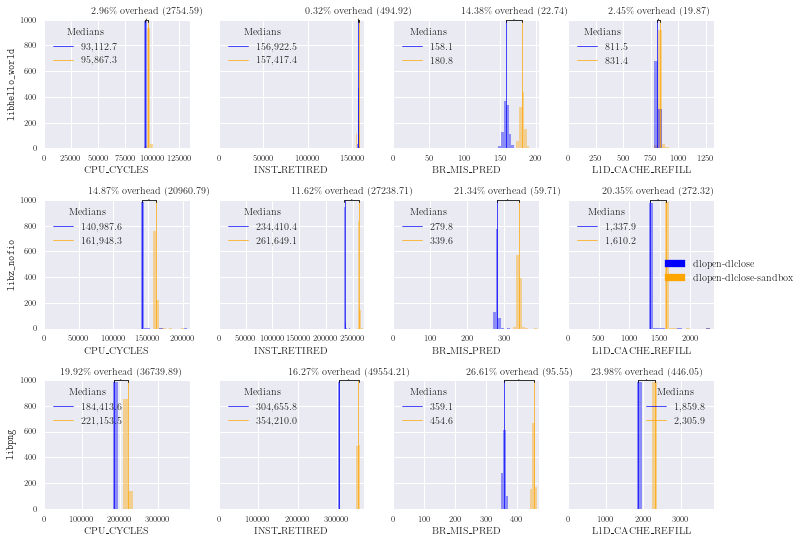

==== dlsym ====
Libraries: {'hello_world_1000'}
Counters: {'CPU_CYCLES', 'INST_RETIRED', 'BR_MIS_PRED', 'L1D_CACHE_REFILL'}


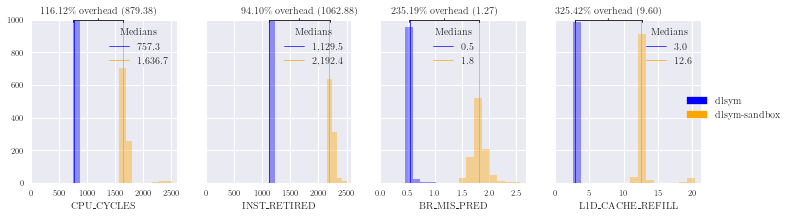

==== function-call ====
Libraries: {'hello_world'}
Counters: {'CPU_CYCLES', 'INST_RETIRED', 'BR_MIS_PRED', 'L1D_CACHE_REFILL'}


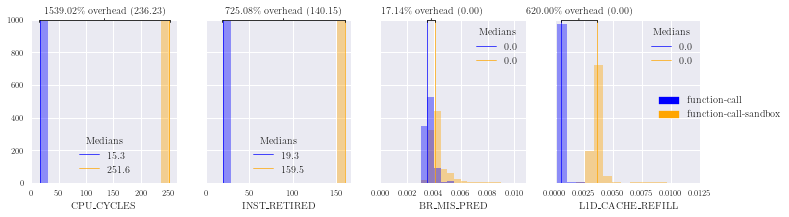

==== lazy-binding ====
Libraries: {'hello_world_with_deps_10'}
Counters: {'CPU_CYCLES', 'INST_RETIRED', 'BR_MIS_PRED', 'L1D_CACHE_REFILL'}


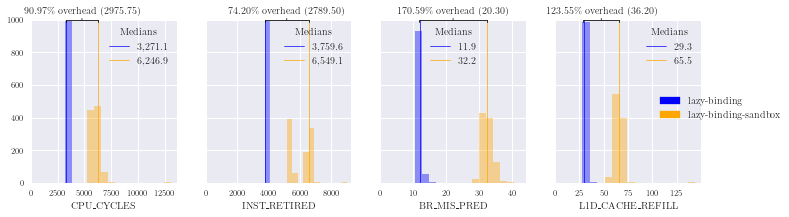

In [440]:
for benchmark in benchmarks:
    print(f"==== {benchmark} ====")
    plot_benchmark_data(
        *load_benchmark_results(benchmark)
    )

In [194]:
def get_web_png_size_distribution():
    with open("../png_sizes.txt", "r") as f:
        widths, heights = [], []
        for png in f.readlines():
            m = re.search('(\\d+) x (\\d+)', png)
            if m is None:
                continue
            width, height = m.groups()
            widths.append(int(width))
            heights.append(int(height))
        widths, heights = np.array(widths), np.array(heights)
        return np.sqrt(widths * heights)
png_sizes = get_web_png_size_distribution()

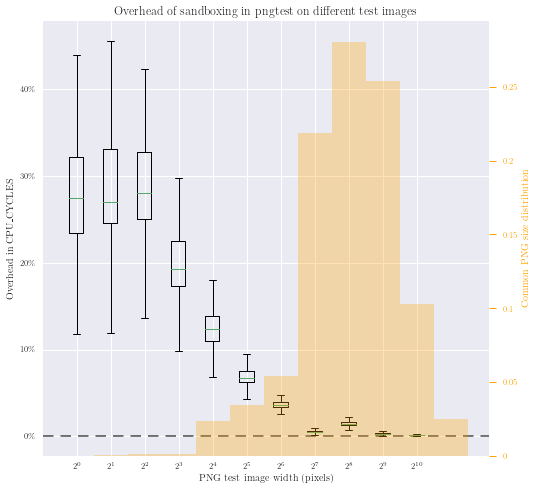

In [195]:
benchmark = "pngtest-parameterised/pngtest-on-testpng32"
counter = "CPU_CYCLES" if 1 else "INST_RETIRED"
mean_baseline, std_baseline, mean_sandbox, std_sandbox, mean_ratio, std_ratio, ratios = [], [], [], [], [], [], []
for i in 2**np.arange(0, 11):
    baseline, sandbox = load_benchmark_results(f"pngtest-parameterised/pngtest-parameterised-1000/pngtest-on-testpng{i}", "pngtest")
    mean_baseline.append(np.mean(baseline.loc[:, counter]))
    std_baseline.append(np.std(baseline.loc[:, counter]))
    mean_sandbox.append(np.mean(sandbox.loc[:, counter]))
    std_sandbox.append(np.std(baseline.loc[:, counter]))
    ratio = sandbox / baseline
    ratios.append(ratio.loc[:, counter])
    mean_ratio.append(np.mean(ratio.loc[:, counter]))
    std_ratio.append(np.std(ratio.loc[:, counter]))

mean_baseline = np.array(mean_baseline)
std_baseline = np.array(std_baseline)
mean_sandbox = np.array(mean_sandbox)
std_sandbox = np.array(std_sandbox)
mean_ratio = np.array(mean_ratio)
std_ratio = np.array(std_ratio)
ratios = np.array(ratios)

# TODO: make two axes for the curve and the ratio

fig, ax = plt.subplots(figsize=(8,8))
# ax.errorbar(2**np.arange(0, 11), mean_baseline, yerr=2*std_baseline, label="baseline")
# ax.errorbar(2**np.arange(0, 11), mean_sandbox,  yerr=2*std_sandbox,  label="sandbox")
# ax.set_yscale("log")
# ax.plot(2**np.arange(0, 11), mean_sandbox / mean_baseline, label="ratio")
# ax.plot(2**np.arange(0, 11), mean_ratio - 1, label=f"{counter} $\\pm 2\\sigma$")
# ax.fill_between(2**np.arange(0, 11), mean_ratio - 1 - 2*std_ratio, mean_ratio - 1 + 2*std_ratio, alpha=0.5)

res = ax.boxplot(ratios.T - 1, positions=2**np.arange(0, 11), widths=0.3*2**np.arange(0, 11), showfliers=False)
boxplot_patch = res["boxes"][0]
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0, symbol="$\%$", is_latex=True))
ax.axhline(y=0, dashes=(6,4), color="black", alpha=0.6)
ax.set_xscale('log')
ax.xaxis.set_major_formatter(mtick.LogFormatterSciNotation(base=2))
ax.xaxis.set_major_locator(mtick.LogLocator(base=2, subs=(1.0,)))
ax.xaxis.set_ticks(ticks=2**np.arange(0, 11))
ax.set_xlabel("PNG test image width (pixels)")
ax.set_ylabel(f"Overhead in {counter}")

ax_hist = ax.twinx()
hist_patch = ax_hist.hist(png_sizes, bins=2**np.arange(0.5,12.5,1), density=False, histtype='stepfilled', color='orange', alpha=0.3)
num_pngs = png_sizes.shape[0]
ax_hist.set_yticks(ticks=num_pngs*np.arange(0, 0.3, 0.05), labels=["$0$", "$0.05$", "$0.1$", "$0.15$", "$0.2$", "$0.25$"], color="orange")
ax_hist.tick_params(which='major', length=7, color="orange")
# ax_hist.set_axis_off()
ax_hist.grid(False)
ax_hist.set_ylabel("Common PNG size distribution", color="orange")

# ax.legend([boxplot_patch, hist_patch[2][0]], ["Relative overhead", "Common PNG size distribution"], loc="lower left")

# ax.set_ybound(-0.05, 0.415)
# ax.legend()
# fig.tight_layout()
ax.set_title("Overhead of sandboxing in pngtest on different test images")
plt.show()

### Ablation study

Root cause analysis, finding what overhead each operation in the function call trampoline is associated with.

In [106]:
ablation_stages = [
    "empty-call-trampoline",
    "clear-caller-saved-regs",
    "return-trampoline-retaddr-on-caller-stack",
    "trusted-stack",
    "clear-and-save-callee-saved-regs",
    "restricted-mode",
    "restrict-sp-fp-bounds",
]

In [196]:
dfs = [load_benchmark_results(f"ablation/ld-{ablation_stages[0]}.so.1", "function-call")[0].median().rename("baseline")]
for stage in ablation_stages:
    baseline, sandbox = load_benchmark_results(f"ablation/ld-{stage}.so.1", "function-call")
    dfs.append(sandbox.median().rename(stage))
ablation = pd.concat(dfs, axis="columns").transpose()
ablation

,CPU_CYCLES,BR_MIS_PRED,INST_RETIRED,L1D_CACHE_REFILL
baseline,15.34950,0.0035,19.3286,0.0005
empty-call-trampoline,21.42465,0.0034,21.3286,0.0008
clear-caller-saved-regs,22.35510,0.0032,26.3286,0.0007
return-trampoline-retaddr-on-caller-stack,29.47915,0.0031,29.3286,0.0007
trusted-stack,246.14520,0.0044,125.4774,0.0033
clear-and-save-callee-saved-regs,248.58225,0.0048,145.4775,0.0035
restricted-mode,252.08385,0.0046,149.4774,0.0035
restrict-sp-fp-bounds,251.59655,0.0047,159.4774,0.0035


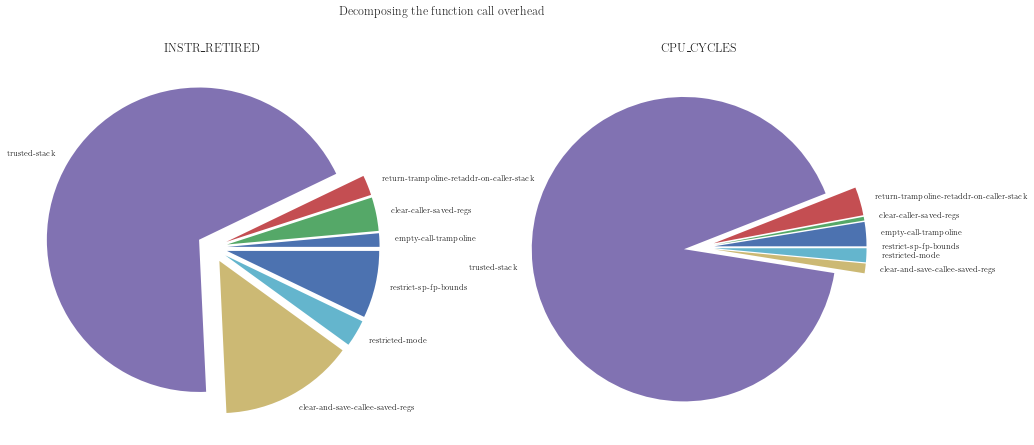

In [197]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 7))
fig.suptitle("Decomposing the function call overhead")

counter = "INST_RETIRED"
distr = ablation[counter].diff()
distr[0] = ablation[counter][0]
distr = np.maximum(distr, 0.1)
ax[0].pie(distr[1:], labels=ablation_stages, explode=[0.1]*len(ablation_stages))
ax[0].set_title("INSTR_RETIRED")

counter = "CPU_CYCLES"
distr = ablation[counter].diff()
distr[0] = ablation[counter][0]
distr = np.maximum(distr, 0)
ax[1].pie(distr[1:], labels=ablation_stages, explode=[0.1]*len(ablation_stages))
ax[1].set_title("CPU_CYCLES")

plt.show()